In [1]:
from timeit import default_timer
import matplotlib.pyplot as plt
import torch
import ml_collections

from wavebench.dataloaders.rtc_loader import get_dataloaders_rtc_mnist
from wavebench.dataloaders.rtc_loader import get_dataloaders_rtc_thick_lines
from wavebench.nn.lploss import LpLoss
from wavebench.plot_utils import remove_frame
from wavebench.nn.fionet_module.fionet import FIONet

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')


# Configs

interpolating images to size 64


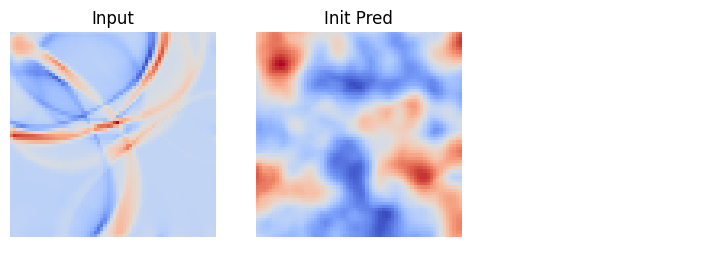

In [2]:
config = ml_collections.ConfigDict()

# data setting
config.train_batch_size = 50
config.eval_batch_size = 50
config.num_workers = 1
config.resize_sidelen = 64

# learning setting
config.learning_rate = 1e-5
config.num_epochs = 20
config.eta_min = 1e-6 # the smallest learning rate in learning rate decay

# model setting
config.model_kwargs = {
  'sidelen': config.resize_sidelen, # 128
  'siren_latent_dim': 512,  # 200
  'siren_num_layers': 5, # 3
  'use_two_routers': True,
  'router_use_curvelet_scales': True,
  'keep_only_curvelet_middle_scales': True}

loaders = get_dataloaders_rtc_thick_lines(
    train_batch_size=config.train_batch_size,
    eval_batch_size=config.eval_batch_size,
    num_workers=config.num_workers,
    resize_sidelen=config.resize_sidelen)

train_loader = loaders['train']
val_loader = loaders['val']

model = FIONet(**config.model_kwargs)

sample_input, sample_target = loaders['train'].dataset[0]

pred = model(sample_input.unsqueeze(0), router_only=True).cpu().detach().numpy()

fig, axs = plt.subplots(1, 3, figsize=(9, 3))

axs[0].imshow(sample_input.squeeze(), cmap='coolwarm')
axs[0].set_title('Input')
axs[1].imshow(sample_target.squeeze(), cmap='coolwarm')
axs[1].set_title('Target')
axs[1].imshow(pred.squeeze(), cmap='coolwarm')
axs[1].set_title('Init Pred')


[remove_frame(ax) for ax in axs.flatten()];
del sample_input, sample_target, model


# Training

In [3]:
model = FIONet(**config.model_kwargs).to(device)

# train_loader = loaders['train']
criterion = LpLoss()
# criterion = torch.nn.L1Loss()
# criterion = torch.nn.MSELoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    config.num_epochs*len(train_loader),
    eta_min=config.eta_min)

# %%
for ep in range(config.num_epochs):
  model.train()
  t1 = default_timer()
  train_l2 = 0
  for x, y in train_loader:
    x, y = x.to(device), y.to(device)

    optimizer.zero_grad()
    out = model(x, router_only=True)
    loss = criterion(out, y)
    loss.backward()

    optimizer.step()
    scheduler.step()
    train_l2 += loss.item()
    # print(loss.item())

  model.eval()
  val_l2 = 0.0
  with torch.no_grad():
    for x, y in val_loader:
      x, y = x.to(device), y.to(device)
      out = model(x, router_only=True)
      val_l2 += criterion(out, y).item()

  train_l2/= len(train_loader)
  val_l2 /= len(val_loader)

  t2 = default_timer()
  print(f'epoch: {ep} | time {t2-t1} | train loss {train_l2} | val loss {val_l2}')



epoch: 0 | time 32.12264550399959 | train loss 1.027933084964752 | val loss 1.0075031757354735


KeyboardInterrupt: 

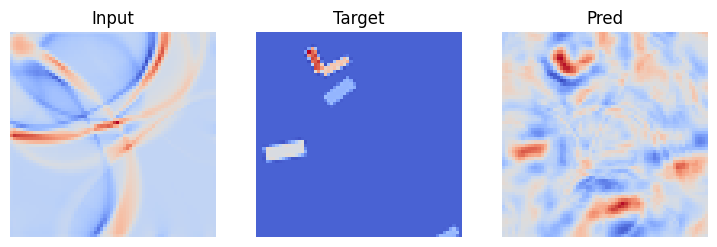

In [ ]:
sample_input, sample_target = train_loader.dataset[0]

with torch.no_grad():
  pred = model(
    sample_input.unsqueeze(0).to(device), router_only=True).detach().cpu().numpy()

fig, axs = plt.subplots(1, 3, figsize=(9, 3))

axs[0].imshow(sample_input.squeeze(), cmap='coolwarm')
axs[0].set_title('Input')
axs[1].imshow(sample_target.squeeze(), cmap='coolwarm')
axs[1].set_title('Target')
axs[2].imshow(pred.squeeze(), cmap='coolwarm')
axs[2].set_title('Pred')


[remove_frame(ax) for ax in axs.flatten()];
del sample_input, sample_target


interpolating images to size 64


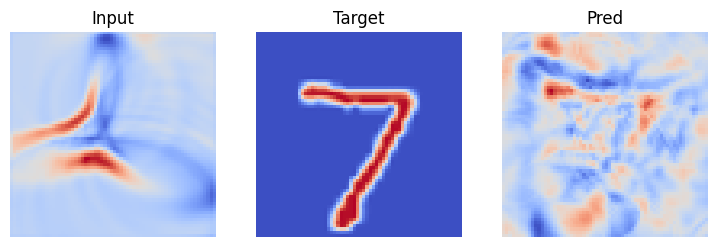

In [ ]:
mnist_loader = get_dataloaders_rtc_mnist(
  medium_type='gaussian_lens',
  resize_sidelen=config.resize_sidelen
)

sample_input, sample_target = mnist_loader.dataset[0]

with torch.no_grad():
  pred = model(sample_input.unsqueeze(0).to(device),
               router_only=True).detach().cpu().numpy()

fig, axs = plt.subplots(1, 3, figsize=(9, 3))

axs[0].imshow(sample_input.squeeze(), cmap='coolwarm')
axs[0].set_title('Input')
axs[1].imshow(sample_target.squeeze(), cmap='coolwarm')
axs[1].set_title('Target')
axs[2].imshow(pred.squeeze(), cmap='coolwarm')
axs[2].set_title('Pred')

[remove_frame(ax) for ax in axs.flatten()];
del sample_input, sample_target